<a href="https://colab.research.google.com/github/daeun118/MachineLearning1/blob/main/%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D_2%EC%B0%A8%ED%8C%80%ED%94%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 데이터 로드

In [3]:
# # 처음 한번만 실행(압축해제)
# zip_path_train = '/content/drive/MyDrive/머신러닝1/2차팀플/train.npy.zip' # train 압축파일 경로
# zip_path_test = '/content/drive/MyDrive/머신러닝1/2차팀플/test.npy.zip' # test 압축파일 경로
# unzip_path = '/content/drive/MyDrive/머신러닝1/2차팀플' # 압축해제 파일 저장할 경로

# # unzip
# !unzip -q $zip_path_train -d $unzip_path
# !unzip -q $zip_path_test -d $unzip_path

In [4]:
data = np.load("/content/drive/MyDrive/머신러닝1/2차팀플/train.npy", allow_pickle=True)
data = data.item()
data_input = data['input']
data_label = data['label']

In [5]:
# 테스트 데이터
test_data = np.load("/content/drive/MyDrive/머신러닝1/2차팀플/test.npy", allow_pickle=True)
test_data = test_data.item()
test_data_input = test_data['input']
test_data_input.shape

(576, 1, 22, 1125)

In [6]:
print("input data shape:", data_input.shape)
print("label data shape:", data_label.shape)

input data shape: (4608, 1, 22, 1125)
label data shape: (4608, 4)


In [7]:
data_label
# 원핫인코딩 형태

array([[0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.]], dtype=float32)

In [8]:
# 원핫인코딩된 라벨을 정수 라벨로 변환
'''
    [0, 0, 0, 1]   # 클래스 3
    [0, 0, 1, 0]   # 클래스 2
    [0, 1, 0, 0]   # 클래스 1
    [1, 0, 0, 0]   # 클래스 0
'''

label = np.argmax(data_label, axis=1)
print("정수 라벨(0~3)으로 변환된 라벨 shape:", label.shape)

정수 라벨(0~3)으로 변환된 라벨 shape: (4608,)


In [9]:
# 각 라벨 개수

# 각 라벨의 빈도 계산
unique_labels, counts = np.unique(label, return_counts=True)

# 라벨별 개수 출력
for lbl, count in zip(unique_labels, counts):
    print(f"Label {lbl}: {count}개")

Label 0: 1152개
Label 1: 1152개
Label 2: 1152개
Label 3: 1152개


# 배드채널 제거

In [10]:
pip install --upgrade mne


In [11]:
data_input.shape


(4608, 1, 22, 1125)

In [12]:
import mne

# 데이터 형태
n_epochs = data_input.shape[0]
n_channels = data_input.shape[2]
n_times = data_input.shape[3]
sfreq = 250  # 샘플링 주파수 (Hz)

# 채널 정보 생성
ch_names = [f'EEG {i+1}' for i in range(n_channels)]
info = mne.create_info(ch_names, sfreq, ch_types='eeg')

# 데이터 형태 변경 (n_epochs, n_channels, n_times)
data_reshaped = data_input.squeeze().transpose(1, 0, 2)
print(data_reshaped.shape)

# 테스트 데이터 형태 변경 (n_epochs, n_channels, n_times)
test_data_reshaped = test_data_input.squeeze().transpose(1, 0, 2)
print(test_data_reshaped.shape)

# (n_channels, n_times_total)로 변경
data_for_raw = data_reshaped.reshape(n_channels, -1)
print(data_for_raw.shape)

# 배드 채널 식별 및 제거를 위한 Raw 객체 생성
raw = mne.io.RawArray(data_for_raw, info)

(22, 4608, 1125)
(22, 576, 1125)
(22, 5184000)
Creating RawArray with float64 data, n_channels=22, n_times=5184000
    Range : 0 ... 5183999 =      0.000 ... 20735.996 secs
Ready.


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).


<ipython-input-13-ab6fade28dea>:3: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  raw.plot_psd(picks='all')  # 모든 채널에 대한 PSD 플롯
<ipython-input-13-ab6fade28dea>:3: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(picks='all')  # 모든 채널에 대한 PSD 플롯


Using matplotlib as 2D backend.


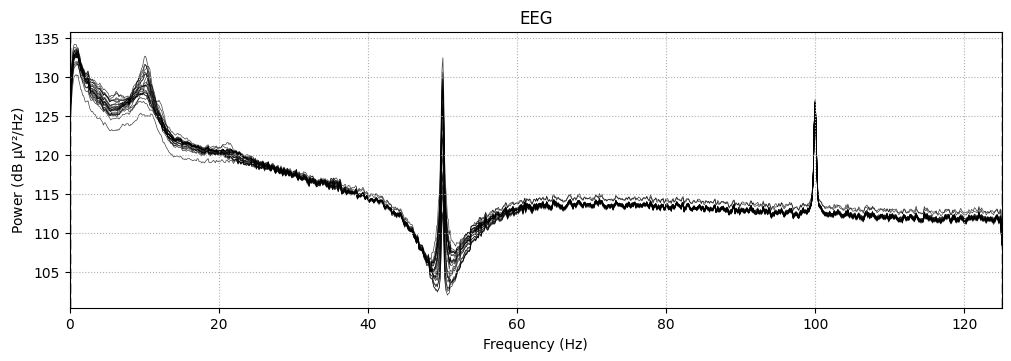

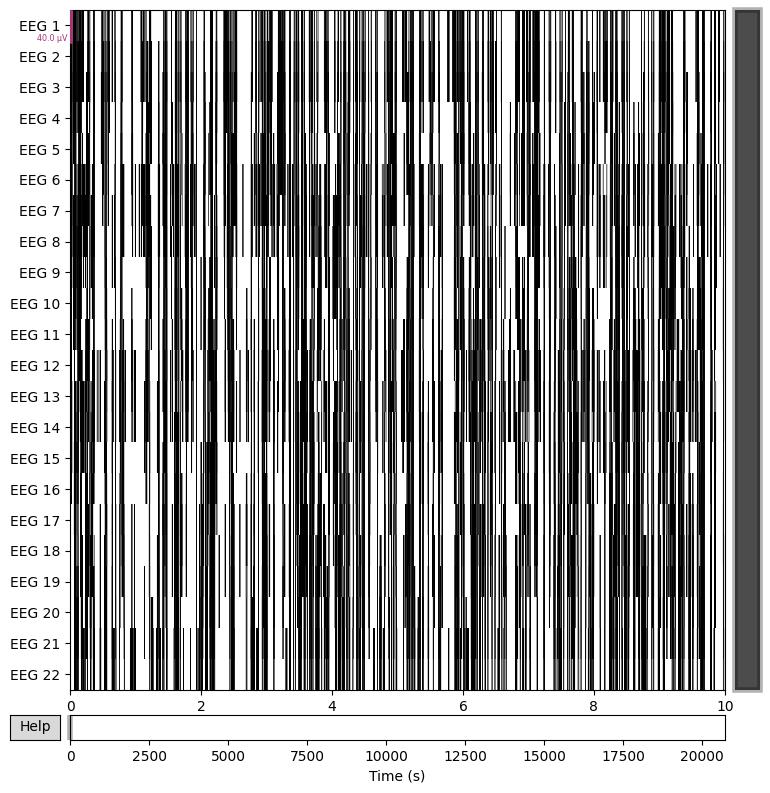

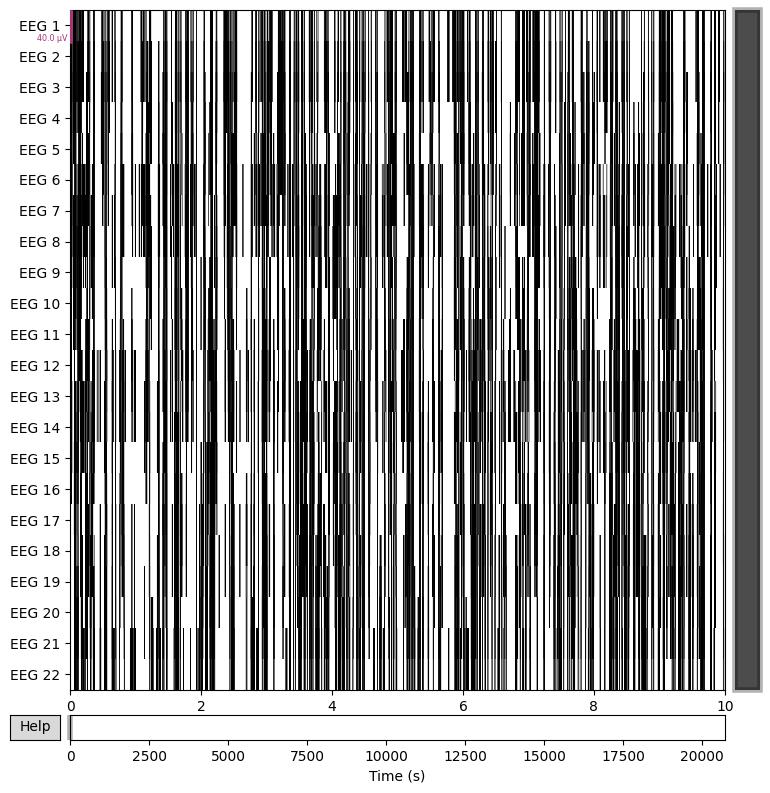

In [13]:
# 배드 채널 식별을 위한 그래프

raw.plot_psd(picks='all')  # 모든 채널에 대한 PSD 플롯
raw.plot(n_channels=n_channels, block=True)  # 모든 채널에 대한 Raw 데이터 플롯

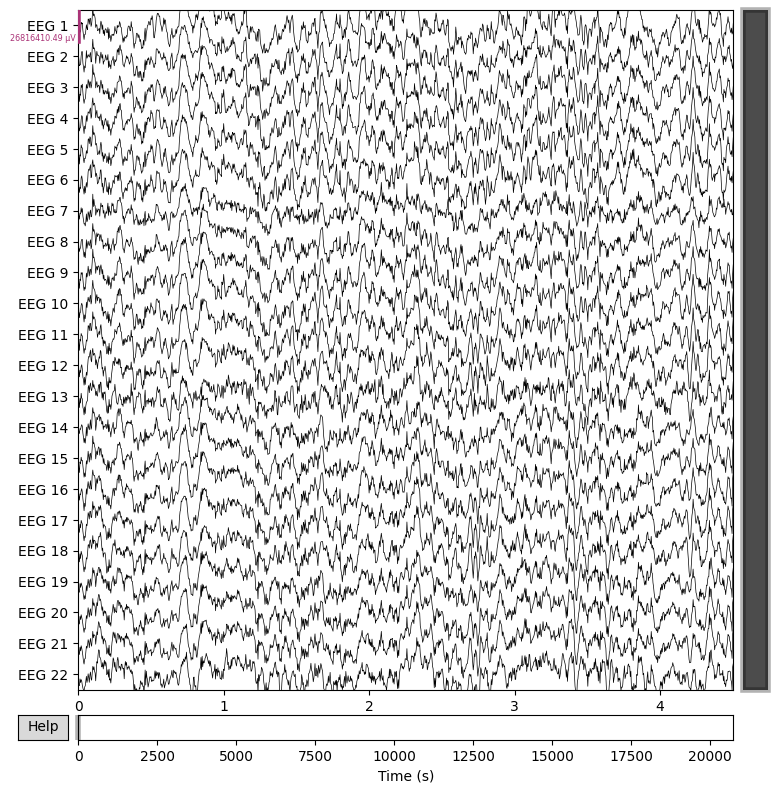

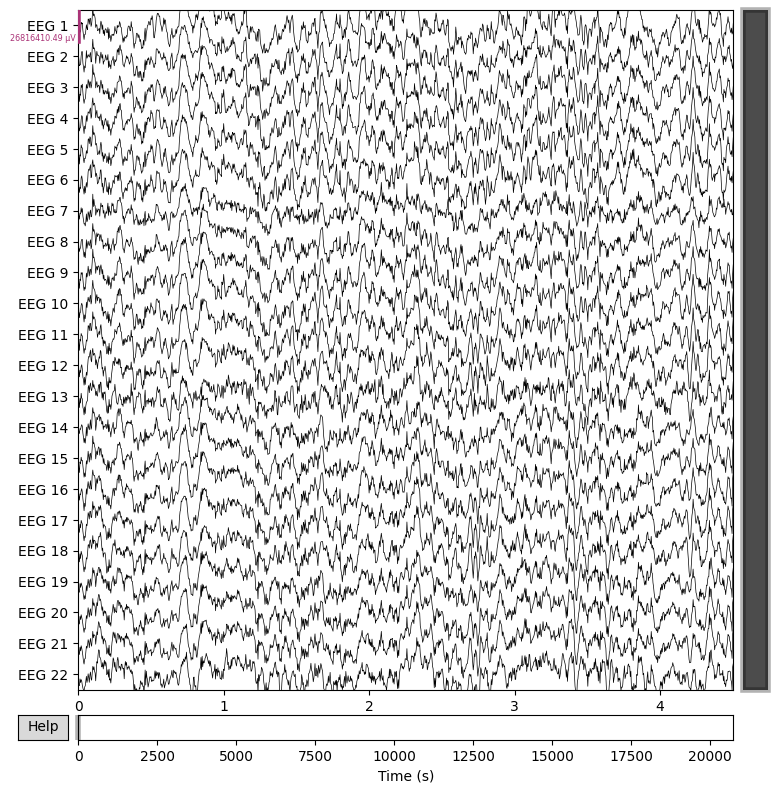

In [14]:
# Raw 데이터 플롯 (첫 4.5초, 22개 채널 표시)
raw.plot(n_channels=22, start=0, duration=4.5, scalings='auto', show_options=True, block=True)


In [15]:
# 채널 7, 8 삭제

# 채널 삭제 (0-based 인덱스)
channels_to_delete = [6, 7]  # 채널 7, 8에 해당하는 인덱스
data_reshaped_cleaned = np.delete(data_reshaped, channels_to_delete, axis=0)
# 테스트 데이터
test_data_reshaped_cleaned = np.delete(test_data_reshaped, channels_to_delete, axis=0)


# 데이터 형태 확인
print("Original shape:", data_reshaped.shape)
print("Shape after deleting channels 7 and 8:", data_reshaped_cleaned.shape)
# 테스트 데이터
print("Shape after deleting channels 7 and 8:", test_data_reshaped_cleaned.shape)

Original shape: (22, 4608, 1125)
Shape after deleting channels 7 and 8: (20, 4608, 1125)
Shape after deleting channels 7 and 8: (20, 576, 1125)


# 각 라벨 해석

*  input data: data_reshaped_cleaned(20, 4608, 1125). 채널 7,8 삭제한 인풋데이터
*  정수 라벨(0~3)으로 변환된 label data: label





In [ ]:
# 라벨별 푸리에변환 결과 시각화(최댓값)

# DC 성분 제거
data_input_detrended = data_reshaped_cleaned - np.mean(data_reshaped_cleaned, axis=-1, keepdims=True)

# MNE RawArray 객체 생성
ch_names = [f'EEG {i+1}' for i in range(data_reshaped_cleaned.shape[0])]
info = mne.create_info(ch_names, sfreq, ch_types='eeg')
data_for_raw = data_input_detrended.reshape(data_reshaped_cleaned.shape[0], -1)
raw = mne.io.RawArray(data_for_raw, info)

# 50Hz와 100Hz 밴드스탑 필터 적용(전력선간섭 제거)
raw.notch_filter(freqs=[50, 100], filter_length='auto', phase='zero')

# 필터링된 데이터를 다시 배열 형태로 변환
filtered_data = raw.get_data().reshape(data_reshaped_cleaned.shape)

# 푸리에 변환 적용
fft_data = np.fft.fft(filtered_data, axis=-1)
fft_magnitude = np.abs(fft_data)

# 주파수 축 생성
freqs = np.fft.fftfreq(filtered_data.shape[-1], d=1/sfreq)

# Y축 최대값 계산
global_max = 0
for lbl in np.unique(label):
    label_indices = np.where(label == lbl)[0]
    if len(label_indices) > sample_size:
        label_indices = np.random.choice(label_indices, sample_size, replace=False)
    label_data = fft_magnitude[:, label_indices, :]
    max_value = np.max(label_data)
    if max_value > global_max:
        global_max = max_value

# 각 라벨별로 데이터 시각화
unique_labels = np.unique(labels)
for lbl in unique_labels:
    # 라벨에 해당하는 데이터 선택 (샘플 크기 제한)
    label_indices = np.where(labels == lbl)[0]
    if len(label_indices) > sample_size:
        label_indices = np.random.choice(label_indices, sample_size, replace=False)

    label_data = fft_magnitude[:, label_indices, :]

    # 각 채널별 주파수 대역의 최대값 계산
    max_fft_magnitude = np.max(label_data, axis=1)  # (channels, frequencies)

    # 시각화
    plt.figure(figsize=(15, 10))
    for channel in range(max_fft_magnitude.shape[0]):
        plt.plot(freqs[:len(freqs)//2], max_fft_magnitude[channel, :len(freqs)//2], label=f'Channel {channel+1}')
    plt.title(f'Label {lbl} - Max FFT Magnitude per Channel')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.ylim(0, global_max)  # Y축 범위 설정
    plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1.05))
    plt.show()

Creating RawArray with float64 data, n_channels=20, n_times=5184000
    Range : 0 ... 5183999 =      0.000 ... 20735.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    6.2s


NameError: name 'labels' is not defined

In [ ]:
# 주파수 대역 설정 (델타, 세타, 알파, 베타, 감마)
bands = {
    'Delta': (0.5, 4),
    'Theta': (4, 8),
    'Alpha': (8, 13),
    'Beta': (13, 30),
    'Gamma': (30, 100)
}

# 각 라벨별로 데이터 시각화
unique_labels = np.unique(labels)
for lbl in unique_labels:
    # 라벨에 해당하는 데이터 선택
    label_indices = np.where(labels == lbl)[0]

    label_data = fft_magnitude[:, label_indices, :]

    # 주파수 대역별로 평균값 계산
    band_means = {}
    for band, (low, high) in bands.items():
        band_indices = np.where((freqs >= low) & (freqs < high))[0]
        band_mean = np.mean(label_data[:, :, band_indices], axis=(0, 1, 2))  # (channels, epochs, frequencies)
        band_means[band] = band_mean

    # 시각화
    plt.figure(figsize=(10, 6))
    plt.bar(band_means.keys(), band_means.values())
    plt.title(f'Label {lbl} - Mean FFT Magnitude per Frequency Band')
    plt.xlabel('Frequency Band')
    plt.ylabel('Mean Magnitude')
    plt.show()

In [ ]:
# 샘플링 크기 설정 (예: 각 라벨에서 500개 샘플 사용)
sample_size = 1152

# 푸리에 변환 적용
# 데이터의 마지막 차원(시간 도메인)을 주파수 도메인으로 변환
fft_data = np.fft.fft(data_input, axis=-1)
fft_magnitude = np.abs(fft_data)

# 주파수 축 생성 (샘플링 주파수는 예를 들어 250Hz로 가정)
sampling_freq = 250  # Hz
freqs = np.fft.fftfreq(data_input.shape[-1], d=1/sampling_freq)

# Y축 최대값 계산
global_max = 0
for lbl in np.unique(label):
    label_indices = np.where(label == lbl)[0]
    if len(label_indices) > sample_size:
        label_indices = np.random.choice(label_indices, sample_size, replace=False)
    label_data = fft_magnitude[label_indices]
    max_value = np.max(label_data)
    if max_value > global_max:
        global_max = max_value

# 각 라벨별로 데이터 시각화
unique_labels = np.unique(label)
for lbl in unique_labels:
    # 라벨에 해당하는 데이터 선택 (샘플 크기 제한)
    label_indices = np.where(label == lbl)[0]
    if len(label_indices) > sample_size:
        label_indices = np.random.choice(label_indices, sample_size, replace=False)

    label_data = fft_magnitude[label_indices]

    # 각 채널별 주파수 대역의 최대값 계산
    max_fft_magnitude = np.max(label_data, axis=0).squeeze()  # (channels, frequencies)

    # 시각화
    plt.figure(figsize=(15, 10))
    for channel in range(max_fft_magnitude.shape[0]):
        plt.plot(freqs[:len(freqs)//2], max_fft_magnitude[channel, :len(freqs)//2], label=f'Channel {channel+1}')
    plt.title(f'Label {lbl} - Max FFT Magnitude per Channel')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.ylim(0, global_max)  # Y축 범위 설정
    plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1.05))
    plt.show()

In [ ]:
# 샘플링 크기 설정 (예: 각 라벨에서 500개 샘플 사용)
sample_size = 1152

# DC 성분 제거
data_input_detrended = data_input - np.mean(data_input, axis=-1, keepdims=True)

# 푸리에 변환 적용
fft_data = np.fft.fft(data_input_detrended, axis=-1)
fft_magnitude = np.abs(fft_data)

# 주파수 축 생성 (샘플링 주파수는 예를 들어 250Hz로 가정)
sampling_freq = 250  # Hz
freqs = np.fft.fftfreq(data_input.shape[-1], d=1/sampling_freq)

# 주파수 대역 설정 (델타, 세타, 알파, 베타, 감마)
bands = {
    'Delta': (0.5, 4),
    'Theta': (4, 8),
    'Alpha': (8, 13),
    'Beta': (13, 30),
    'Gamma': (30, 100)
}

# 각 라벨별로 데이터 시각화
unique_labels = np.unique(label)
for lbl in unique_labels:
    # 라벨에 해당하는 데이터 선택 (샘플 크기 제한)
    label_indices = np.where(label == lbl)[0]
    if len(label_indices) > sample_size:
        label_indices = np.random.choice(label_indices, sample_size, replace=False)

    label_data = fft_magnitude[label_indices]

    # 주파수 대역별로 평균값 계산
    band_means = {}
    for band, (low, high) in bands.items():
        band_indices = np.where((freqs >= low) & (freqs < high))[0]
        band_mean = np.mean(label_data[:, :, :, band_indices], axis=(0, 1, 2, 3))
        band_means[band] = band_mean

    # 시각화
    plt.figure(figsize=(10, 6))
    plt.bar(band_means.keys(), band_means.values())
    plt.title(f'Label {lbl} - Mean FFT Magnitude per Frequency Band')
    plt.xlabel('Frequency Band')
    plt.ylabel('Mean Magnitude')
    plt.show()

In [ ]:
# 샘플링 크기 설정 (예: 각 라벨에서 500개 샘플 사용)
sample_size = 1152

# DC 성분 제거
data_input_detrended = data_input - np.mean(data_input, axis=-1, keepdims=True)

# 푸리에 변환 적용
fft_data = np.fft.fft(data_input_detrended, axis=-1)
fft_magnitude = np.abs(fft_data)

# 주파수 축 생성 (샘플링 주파수는 예를 들어 250Hz로 가정)
sampling_freq = 250  # Hz
freqs = np.fft.fftfreq(data_input.shape[-1], d=1/sampling_freq)

# 주파수 대역 설정 (뮤 리듬, 베타파)
bands = {
    'Mu': (8, 12),
    'Beta': (13, 30)
}

# 각 라벨별로 데이터 시각화
unique_labels = np.unique(label)
for lbl in unique_labels:
    # 라벨에 해당하는 데이터 선택 (샘플 크기 제한)
    label_indices = np.where(label == lbl)[0]
    if len(label_indices) > sample_size:
        label_indices = np.random.choice(label_indices, sample_size, replace=False)

    label_data = fft_magnitude[label_indices]

    # 주파수 대역별로 평균값 계산
    band_means = {}
    for band, (low, high) in bands.items():
        band_indices = np.where((freqs >= low) & (freqs < high))[0]
        band_mean = np.mean(label_data[:, :, :, band_indices], axis=(0, 1, 2, 3))
        band_means[band] = band_mean

    # 시각화
    plt.figure(figsize=(10, 6))
    plt.bar(band_means.keys(), band_means.values())
    plt.title(f'Label {lbl} - Mean FFT Magnitude per Frequency Band')
    plt.xlabel('Frequency Band')
    plt.ylabel('Mean Magnitude')
    plt.show()

# 모델링

*  input data: data_reshaped_cleaned(20, 4608, 1125). 채널 7,8 삭제한 인풋데이터
*  정수 라벨(0~3)으로 변환된 label data: label

* 0,3 = 0 / 1,2 = 1로 변환한 label data: new_label

In [16]:
# 라벨을 이진 라벨로 변환
new_label = np.where(np.isin(label, [0, 3]), 0, 1)
new_label

array([0, 1, 1, ..., 1, 0, 1])

## data split

In [17]:
from sklearn.model_selection import train_test_split

# 데이터와 라벨 설정
X = data_reshaped_cleaned
y = new_label

# 데이터의 첫 번째 축과 두 번째 축을 바꿈
X_reshaped = np.transpose(X, (1, 0, 2))  # (4608, 20, 1125)

# train_test_split 사용
X_train, X_valid, y_train, y_valid = train_test_split(X_reshaped, y, test_size=0.2, random_state=42, stratify=y)

# 나눈 후 다시 원래 형태로 변환
X_train = np.transpose(X_train, (1, 0, 2))  # (20, 3686, 1125)
X_valid = np.transpose(X_valid, (1, 0, 2))  # (20, 922, 1125)

# 테스트 데이터
X_test = test_data_reshaped_cleaned

print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape)
print("X_valid shape:", X_valid.shape, "y_valid shape:", y_valid.shape)
print("X_test shape:", X_test.shape)


X_train shape: (20, 3686, 1125) y_train shape: (3686,)
X_valid shape: (20, 922, 1125) y_valid shape: (922,)
X_test shape: (20, 576, 1125)


## 각 채널에 대해 스케일링

In [18]:
from sklearn.preprocessing import StandardScaler

# 각 채널별로 스케일링
scalers = []
for i in range(X_train.shape[0]):
    scaler = StandardScaler()
    X_train[i] = scaler.fit_transform(X_train[i])
    X_valid[i] = scaler.transform(X_valid[i])
    X_test[i] = scaler.transform(X_test[i])
    scalers.append(scaler)

print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape)
print("X_valid shape:", X_valid.shape, "y_valid shape:", y_valid.shape)
print("X_test shape:", X_test.shape)

X_train shape: (20, 3686, 1125) y_train shape: (3686,)
X_valid shape: (20, 922, 1125) y_valid shape: (922,)
X_test shape: (20, 576, 1125)


# cnn

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Set random seed for reproducibility
np.random.seed(0)
torch.manual_seed(0)

In [20]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("We're using:", device)

We're using: cuda


In [21]:
# 데이터 로드 및 형식 변환
X_train = np.transpose(X_train, (1, 2, 0)).reshape(3686, 1, 20, 1125)
X_valid = np.transpose(X_valid, (1, 2, 0)).reshape(922, 1, 20, 1125)
X_test = np.transpose(X_test, (1, 2, 0)).reshape(576, 1, 20, 1125)

# NumPy 배열을 PyTorch 텐서로 변환
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_valid_tensor = torch.tensor(X_valid, dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# 데이터셋 및 데이터로더 생성
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)
test_dataset = TensorDataset(X_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [22]:
class EEGClassifier(nn.Module):
    def __init__(self):
        super(EEGClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        # Initialize a dummy tensor to find out the output size of conv layers
        dummy_input = torch.zeros(1, 1, 20, 1125)
        dummy_output = self.pool(self.pool(self.pool(
            torch.relu(self.conv3(torch.relu(self.conv2(torch.relu(self.conv1(dummy_input)))))))))
        self.flat_dim = dummy_output.numel()

        self.fc1 = nn.Linear(self.flat_dim, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, self.flat_dim)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)  # No activation function here
        return x

model = EEGClassifier()


In [23]:
# 손실 함수 및 옵티마이저 정의
criterion = nn.CrossEntropyLoss()  # 이진 분류용 손실 함수
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 모델 훈련
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = outputs.squeeze()  # output shape 맞추기
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}')


Epoch 1/10, Loss: 55.0793536017681
Epoch 2/10, Loss: 54.94278547681611
Epoch 3/10, Loss: 54.89590831460624
Epoch 4/10, Loss: 54.89718169179456
Epoch 5/10, Loss: 54.86412184813927
Epoch 6/10, Loss: 54.75648668716694
Epoch 7/10, Loss: 54.60483620495632
Epoch 8/10, Loss: 54.56314171285465
Epoch 9/10, Loss: 54.28550906016909
Epoch 10/10, Loss: 54.22181695699692


In [24]:
# 모델 검증
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in valid_loader:
        outputs = model(inputs)
        predicted = torch.argmax(outputs, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Validation Accuracy: {100 * correct / total:.2f}%')

Validation Accuracy: 50.00%


# test data 예측

In [25]:
# 모델 예측
model.eval()
predictions = []

with torch.no_grad():
    for inputs in test_loader:
        outputs = model(inputs[0])
        predicted = torch.sigmoid(outputs).squeeze()  # 이진 분류의 경우 확률로 변환
        predictions.extend(predicted.cpu().numpy())

# 예측 결과를 이진 클래스로 변환 (0 또는 1)
predictions = [1 if p > 0.5 else 0 for p in predictions]

# 결과 출력 또는 저장
print(predictions)

[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [27]:
# 제출하기

id=np.arange(576)
target = predictions

submission_df=pd.DataFrame({'ID':id, 'Target':target})

submission_df

,ID,Target
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
571,571,0
572,572,0
573,573,0
574,574,0


In [28]:
submission_df.mean()

ID        287.500000
Target      0.071181
dtype: float64

In [29]:
# csv 파일로 내보내기

submission_df.to_csv('submission_05241.csv',index = False)